## Optimizing the parameters of weighted graphs

In this How-To we optimize QAOA parameters for a graph with weighted edges. In particular we leverage the work of Sureshbabu *et al.*, Quantum **8**, 1231 (2024). In this work, the authors first derive the parameters for unweighted graphs $(\beta, \gamma)$ and then derive parameters for the weighted graphs by rescaling $\gamma$ following
\begin{align}
\gamma \to \frac{\gamma}{\sqrt{E(w^2)}}
\end{align}
where $E(w^2)$ is the second moment of the distribution form which the edges are drawn.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from qaoa_training_pipeline.utils.graph_utils import load_graph, graph_to_operator
from qaoa_training_pipeline.training import DepthOneScanTrainer, ReweightingTrainer, ScipyTrainer
from qaoa_training_pipeline.evaluation import EfficientDepthOneEvaluator, MPSEvaluator

In [4]:
graph = load_graph("../data/problems/example_weighted_graph.json")
cost_op = graph_to_operator(graph)

Here, we estimate the second moment of the edge weight distribution as the standard deviation. The scaling factor for $\gamma$ is thus its square root.

In [29]:
scale_factor = np.sqrt(np.std([edge[2]["weight"]**2 for edge in graph.edges(data=True)]))
print(f"Gamma rescaling factor {scale_factor:.2f}")

Gamma rescaling factor 4.23


## Depth-one QAOA

We compare parameter finding with three methods:

1. A grid-scan which requires a very fine mesh.
2. A SciPy optimization starting from a random initial point.
3. The method of Sureshbabu *et al.* in which we first optimize $(\beta, \gamma)$ for the unweighted graph and then use the rescaled optimal point for the weighted graph.

In [5]:
# Efficient depth-one scan trainer.
trainer1 = DepthOneScanTrainer(EfficientDepthOneEvaluator())

# SciPy trainer to start from a random initial point.
trainer2 = ScipyTrainer(EfficientDepthOneEvaluator(), {"options": {"maxiter": 40, "rhobeg": 0.2}})

# Re-weighting trainer.
unweighted_trainer = DepthOneScanTrainer(EfficientDepthOneEvaluator())
reweighted_trainer = ScipyTrainer(EfficientDepthOneEvaluator(), {"options": {"maxiter": 40, "rhobeg": 0.1}})
trainer3 = ReweightingTrainer(unweighted_trainer, reweighted_trainer)

In [7]:
result1 = trainer1.train(cost_op, num_points=80, parameter_ranges=[(0, np.pi/2), (0, np.pi/2)])
print(result1)

{'optimized_params': [0.39766995615060674, 0.05965049342259102], 'energy': 18.265824491680537, 'trainer': {'trainer_name': 'DepthOneScanTrainer', 'evaluator': {'name': 'EfficientDepthOneEvaluator'}}, 'num_points': 80, 'parameter_ranges': [(0, 1.5707963267948966), (0, 1.5707963267948966)], 'train_duration': 12.833354711532593}


In [15]:
result2 = trainer2.train(cost_op, params0=np.random.uniform(0, np.pi/2, 2))
print(result2["optimized_params"])

[0.9878535701742128, 0.5973480744651533]


In [16]:
result3 = trainer3.train(cost_op, trainer1_kwargs={"num_points": 40, "parameter_ranges": [(0, np.pi/2), (0, np.pi/4)]})
print(result3["optimized_params"])

[0.41457818894060616, 0.06470557517383321]


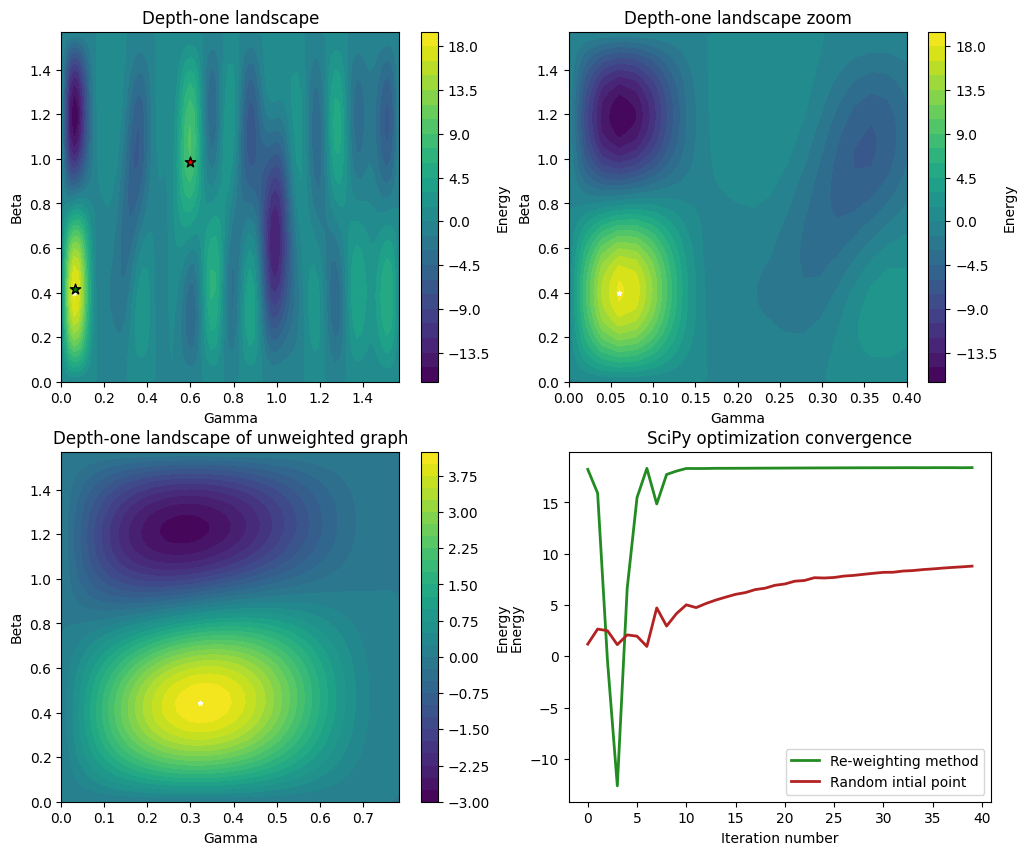

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
trainer1.plot(axis=axs[0][0], fig=fig)
trainer1.plot(axis=axs[0][1], fig=fig)
trainer3.unweighted_trainer.plot(axis=axs[1][0], fig=fig)
axs[0][0].scatter(result3["optimized_params"][1], result3["optimized_params"][0], s=60, color="g", marker="*", ec="k")
axs[0][0].scatter(result2["optimized_params"][1], result2["optimized_params"][0], s=60, color="r", marker="*", ec="k")
trainer3.weighted_trainer.plot(axis=axs[1][1], fig=fig, color="forestgreen", label="Re-weighting method")
trainer2.plot(axis=axs[1][1], fig=fig, color="firebrick", label="Random intial point")
axs[0][1].set_xlim([0, 0.4])
axs[1][1].legend()
axs[0][0].set_title("Depth-one landscape")
axs[0][1].set_title("Depth-one landscape zoom")
axs[1][0].set_title("Depth-one landscape of unweighted graph")
axs[1][1].set_title("SciPy optimization convergence");

From the figures above we see that the optimization landscape of the weighted problem is very complex with many local minima. This causes a direct optimization with SciPy to get stuck in local optima, see the red star in the top right panel. However, the unweighted problem has a much smoother optimization landscape. Furthermore, we see in the top panels that the global optima of the weighted problem are compressed towards $\gamma=0$. These optima correspond to the optima in the lower left panel located closest to $\gamma=0$. Crucially, we see that, for example, the $\gamma$ values of the optima close to $\gamma=0$ for the unweighted graph can be rescaled to obtain a good initial guess to find the optima of the weighted graph. This gives some visual intuition as to why the rescaling above can produce good initial points.

In [34]:
print("Optimal gamma value for the unweighted graph: ", result1["optimized_params"][0])
print("Initial guess based on rescaled gamma: ", result1["optimized_params"][0] / scale_factor)
print("Optimal gamma value for the weighted graph: ", result3["optimized_params"][1])

Optimal gamma value for the unweighted graph:  0.39766995615060674
Initial guess based on rescaled gamma:  0.0940069396447286
Optimal gamma value for the weighted graph:  0.06470557517383321


## Depth-two QAOA

We now repeat the same procedure for depth-two QAOA.

In [10]:
# SciPy trainer to start from a random initial point.
trainer4 = ScipyTrainer(MPSEvaluator(threshold_circuit=0.001), {"options": {"maxiter": 40, "rhobeg": 0.2}})

# Re-weighting trainer.
unweighted_trainer = ScipyTrainer(MPSEvaluator(threshold_circuit=0.001), {"options": {"maxiter": 40, "rhobeg": 0.2}})
reweighted_trainer = ScipyTrainer(MPSEvaluator(threshold_circuit=0.001), {"options": {"maxiter": 40, "rhobeg": 0.1}})
trainer5 = ReweightingTrainer(unweighted_trainer, reweighted_trainer)

In [11]:
params0 = np.random.uniform(0, np.pi, 4)
result4 = trainer4.train(cost_op, params0=params0)
print(result4["optimized_params"])

[2.034550138355232, 3.2290678955734125, 1.513019366054104, 2.1001496689248853]


In [12]:
result5 = trainer5.train(cost_op, trainer1_kwargs={"params0": params0})
print(result5["optimized_params"])

[1.7677399168142458, 3.5993250476534553, 0.3038929899369598, 0.3970093778959912]


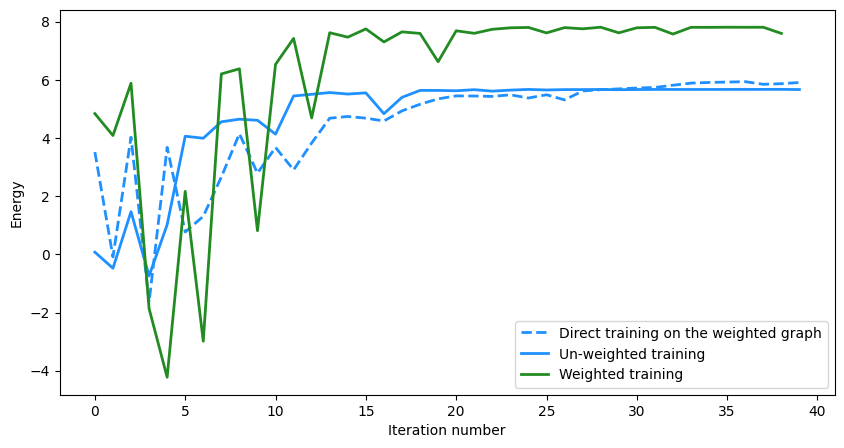

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
trainer4.plot(axis=axs, fig=fig, ls="--", label="Direct training on the weighted graph")
trainer5.unweighted_trainer.plot(axis=axs, fig=fig, color="dodgerblue", label="Un-weighted training")
trainer5.weighted_trainer.plot(axis=axs, fig=fig, color="forestgreen", label="Weighted training")
axs.legend()

Note: the results above differ very significantly depending on the initial point `params0`. Depending on the initial point and optimizer settings, a direct optimization on the weighted graph can outperform the unweighting and re-weighting methodology. In the example above, applying a standard SciPy trainer directly to the weighted graph using a random initial point $x_0$ results in the dashed blue line above. We can obtain a better energy if we instead (i) start the training from the same $x_0$ but on an unweighted graph first to generate a new initial point $x_0'$. Next, (ii) this $x_0'$ is used as the initial point for the training on the weighted graph with SciPy. This two-step process is shown by the solid lines in the plot above. We can see that the solid green line reaches a higher energy than the dashed blue line.